In [1]:
# asume que los datos estan en ../data/<año>.csv.bz2
# fixme: poner el directorio de data que esté en el repo cuando pusheen los pibes

import seaborn as sns
import matplotlib.pyplot as plt

import fnmatch

import pandas as pd
import time
import os
import shutil
#sns.set(color_codes=True)

# load data
tmp_dir = "./tmp_csv/"
#years = ["2006", "2007"]
years = ["2007"]

## Procesar datos

2007.csv


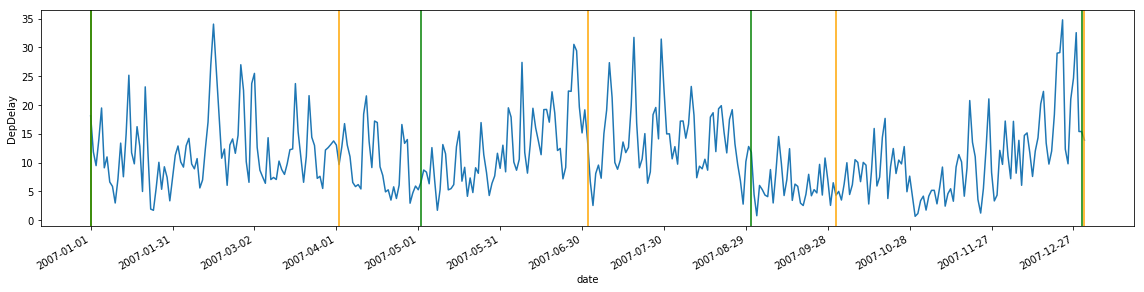

In [3]:
for filename in os.listdir(tmp_dir):
    if filename.endswith(".csv") and filename != "merged.csv": 
        print(filename)
        df = pd.read_csv(tmp_dir+filename)
        fig, ax = plt.subplots(figsize=(16,4))
        sns.lineplot(x=df.date, y=df.DepDelay, linestyle='-')
        plt.xticks(plt.xticks()[0], df.date, rotation=90)
        plt.tight_layout()
        xticks = ax.xaxis.get_major_ticks()
        for i in range(len(xticks)):
            if i%30 != 0:
                xticks[i].set_visible(False)
            if i%int((len(xticks))/4) == 0:    
                plt.axvline(x=i, color="orange")
            if i%int((len(xticks))/3) == 0:    
                plt.axvline(x=i, color="green")
        fig.autofmt_xdate()
        plt.show()
        
#Trimestres en verde, cuatrimestres en naranja

In [4]:
#merge
df = pd.DataFrame(columns=["date", "DepDelay", "ArrDelay"])
for filename in os.listdir(tmp_dir):
    if filename.endswith(".csv") and filename != "merged.csv":
        print(filename)
        df_input = pd.read_csv(tmp_dir+filename)
        df = pd.concat([df, df_input], sort=False)
df.to_csv(tmp_dir+"merged.csv")

2007.csv


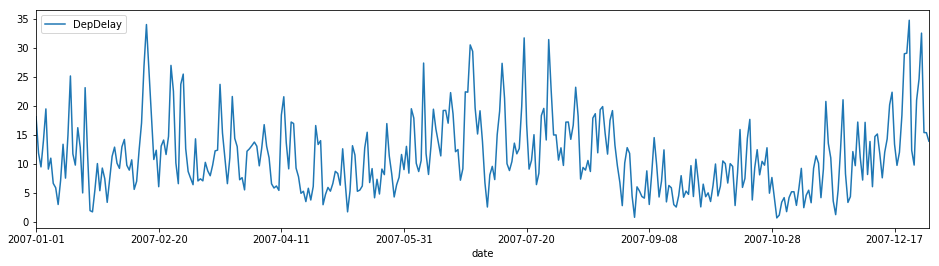

In [5]:
df = pd.read_csv(tmp_dir+"merged.csv")
df.plot(x="date", y="DepDelay", linestyle='-', figsize=(16,4))

## CML acá 

In [6]:
delays = df["DepDelay"]
print(delays)
len(delays)

0      18.117684
1      11.838988
2       9.460353
3      13.983678
4      19.477794
5       9.081797
6      10.971949
7       6.618915
8       5.855902
9       2.969311
10      7.120498
11     13.373440
12      7.525926
13     14.959709
14     25.170928
15     11.707344
16      9.775126
17     16.231193
18     12.832924
19      4.968042
20     23.148879
21     11.631271
22      1.911618
23      1.696038
24      5.551248
25     10.039174
26      5.350126
27      9.261190
28      7.430845
29      3.340663
         ...    
335    17.208948
336    11.176236
337     7.189956
338    17.159487
339     8.148300
340    13.858177
341     6.042499
342    14.705391
343    15.143814
344    11.704068
345     7.576592
346    11.995457
347    14.305226
348    20.194575
349    22.360465
350    13.378115
351     9.727228
352    11.989755
353    18.349023
354    29.005389
355    29.111305
356    34.795426
357    12.318295
358     9.778901
359    21.002253
360    24.671085
361    32.571997
362    15.3943

365

In [14]:
import numpy as np
import math

n = 5
phases = [i*math.pi/2 for i in range(4)]

# semanas, meses, bimestres, trimestres, cuatrimestres, semestres, años
freqs =  [7] + [355/i for i in [12, 6, 4, 3, 2, 1]]

def trig_vals(t):
    return  [math.sin(2 * math.pi / f * t + p) for f in freqs for p in phases] + \
            [math.cos(2 * math.pi / f * t + p) for f in freqs for p in phases]

A = np.array([])
arrays = []
for i in range(len(delays)):
    row = np.array([i**p for p in range(n+1)] + trig_vals(i))
    arrays.append(row)

A = np.stack(arrays)
print(A.shape)

coefs = np.linalg.lstsq(A, delays, rcond=None)[0]
coefs_normal = np.linalg.solve(A.T@A, A.T@delays)


(365, 62)


In [15]:

from cml import svd_solver as ss
coefs_svd = ss.lstsq(A, delays)

from cml import normal_equations_solver as nes
coefs_nes = nes.lstsq(A, delays)

from cml import qr_solver as qr_fast
coefs_qr_fast = qr_fast.lstsq(A, delays)
from cml import qr_col_pivot_solver as qr_col
coefs_qr_col = qr_col.lstsq(A, delays)
from cml import qr_full_pivot_solver as qr_full
coefs_qr_full = qr_full.lstsq(A, delays)


In [16]:
df["dl_pred"] = A@coefs
df["dl_pred_normal"] = A@coefs_normal

df["dl_pred_nes"] = A@coefs_nes
df["dl_pred_svd"] = A@coefs_svd

df["dl_pred_qr"] = A@coefs_qr_fast
df["dl_pred_qr_col"] = A@coefs_qr_col
df["dl_pred_qr_full"] = A@coefs_qr_full

<Figure size 432x288 with 0 Axes>

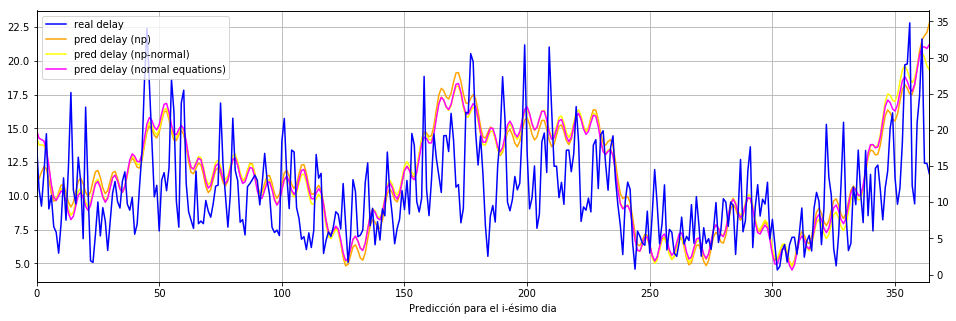

<Figure size 432x288 with 0 Axes>

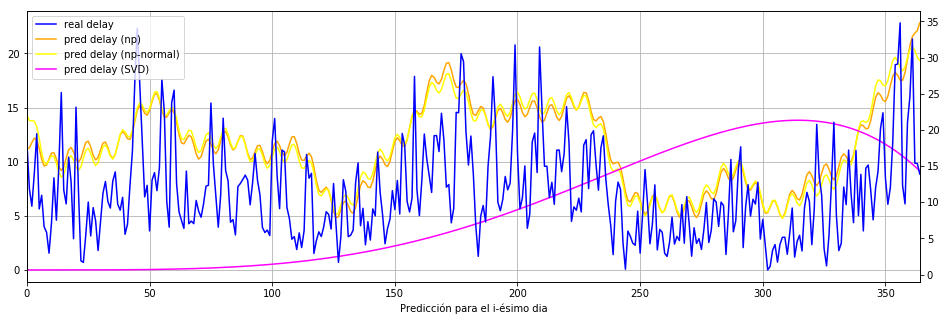

<Figure size 432x288 with 0 Axes>

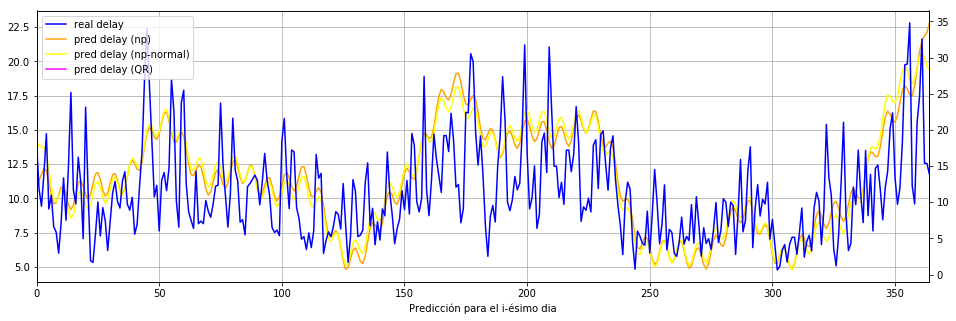

<Figure size 432x288 with 0 Axes>

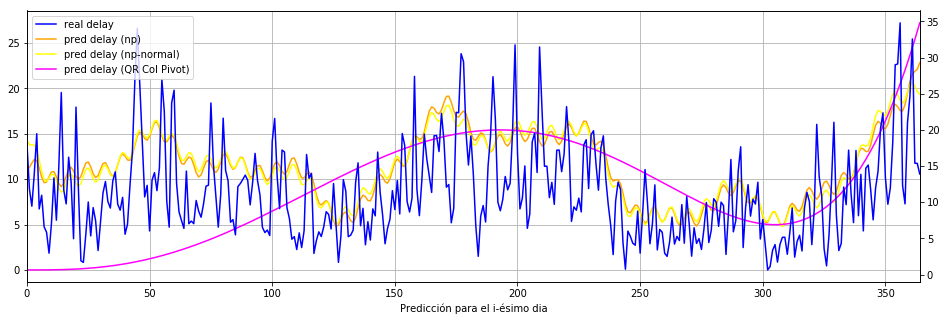

<Figure size 432x288 with 0 Axes>

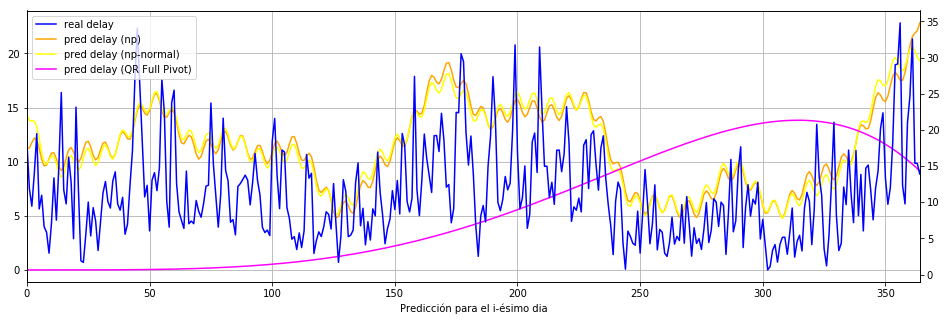

In [17]:
def plot_impl(impl_df, impl_label):

    plt.clf()

    plt.figure(figsize=(16,5))
    plt.xlabel('Predicción para el i-ésimo dia')

    ax1 = df.DepDelay.plot(color='blue', grid=True, secondary_y=True, label='real delay')
    ax2 = df.dl_pred.plot(color='orange', grid=True, label='pred delay (np)')
    ax3 = df.dl_pred_normal.plot(color='yellow', grid=True, label='pred delay (np-normal)')

    ax4 = df[impl_df].plot(color='magenta', grid=True, label=impl_label)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()

    plt.legend(h1+h2, l1+l2, loc=2)
    plt.show()

plot_impl("dl_pred_nes", "pred delay (normal equations)")
plot_impl("dl_pred_svd", "pred delay (SVD)")
plot_impl("dl_pred_qr", "pred delay (QR)")
plot_impl("dl_pred_qr_col", "pred delay (QR Col Pivot)")
plot_impl("dl_pred_qr_full", "pred delay (QR Full Pivot)")


In [ ]:
def build_A(data):
    A = np.array([])
    arrays = []
    for i in range(len(data)):
        row = np.array([i**p for p in range(n+1)] + trig_vals(i))
        arrays.append(row)

    A = np.stack(arrays)
    return A

from sklearn.model_selection import TimeSeriesSplit
from sklearn import svm

tscv = TimeSeriesSplit(n_splits=3)

scores=[]
for train, test in tscv.split(df["DepDelay"]):
    A = build_A(train)
#    coefs = np.linalg.solve(A.T@A, A.T@train)
#    dl_pred_train = A@coefs
#    print(train.shape)
#    print(dl_pred_train.shape)
#    clf = svm.SVC(kernel='linear', C=1).fit(train, dl_pred_train)

#    A2 =  build_A(test)
#    dl_pred = A2@coef
#    scores.append(clf.score(test, dl_pred))

print(scores)


## BORRAR ARCHIVOS

In [12]:
#borrar aux de años
for filename in os.listdir(tmp_dir):
    if fnmatch.fnmatch(filename, '*.csv') and filename != "merged.csv":
        os.remove(tmp_dir+filename)

In [13]:
#borrar tmp
shutil.rmtree(tmp_dir)